# Visualise Temp data

In [ ]:
import pandas as pd
import plotly.express as px

# Read data from CSV file
df = pd.read_csv("cleaned_temp_data.csv")

# Create the map
fig = px.scatter_mapbox(df,
                        lat="latitude",
                        lon="longitude",
                        color="7day_max_temp",
                        size="7day_max_temp",
                        color_continuous_scale=px.colors.sequential.Viridis,
                        size_max=7.5,
                        zoom=3,
                        center={"lat": 20.5937, "lon": 78.9629},  # Center of India
                        mapbox_style="open-street-map",
                        title="50% 7-Day Max Temperatures in India")

# Update the layout
fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    coloraxis_colorbar=dict(title="Temperature (°C)")
)

# Show the plot
fig.show()

#Test Train Split -->selection of best model



Performing kriging with linear variogram model:


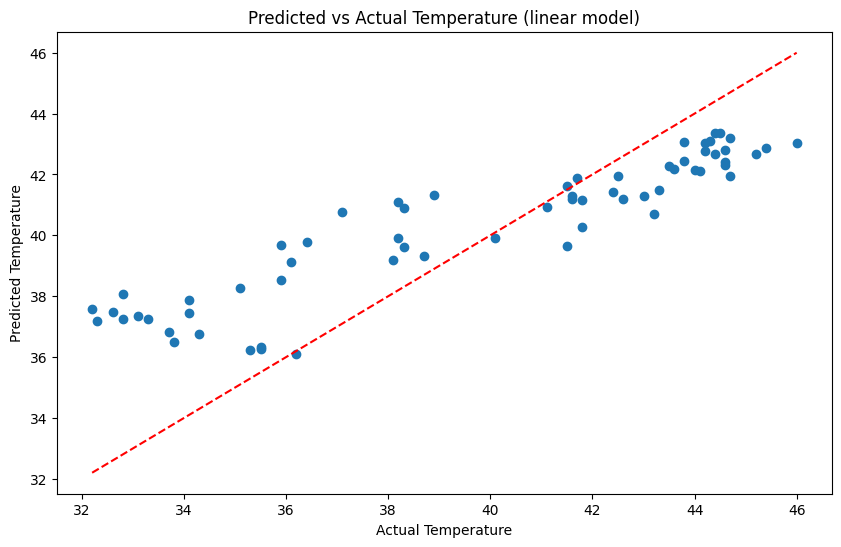

Mean Squared Error: 6.1167
R2 Score: 0.6755

Performing kriging with power variogram model:


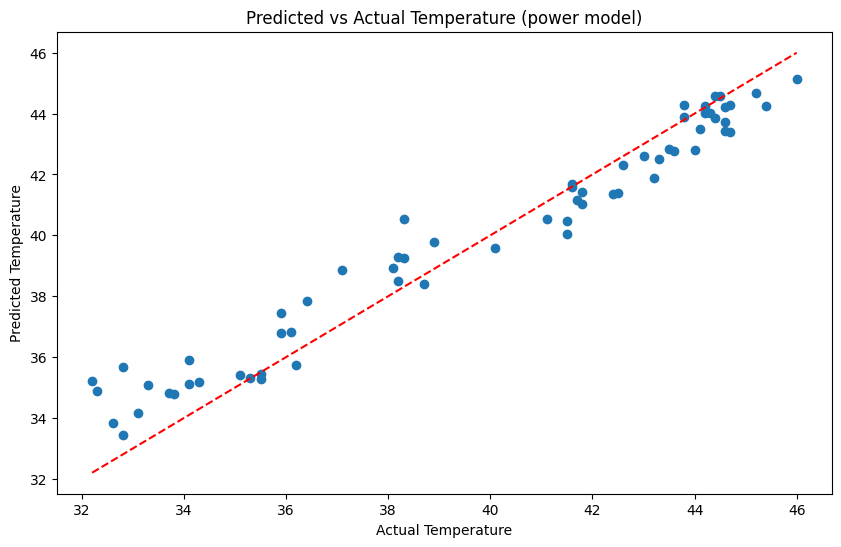

Mean Squared Error: 1.1757
R2 Score: 0.9376

Performing kriging with gaussian variogram model:


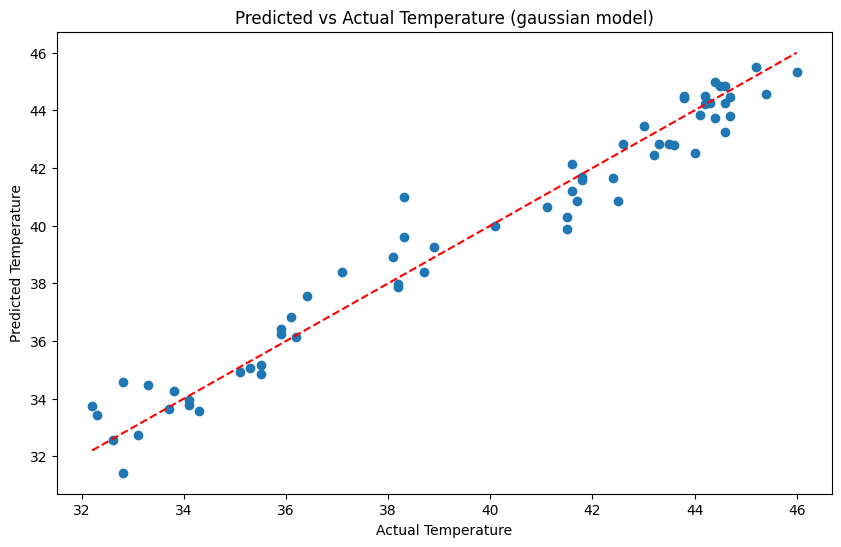

Mean Squared Error: 0.6992
R2 Score: 0.9629

Performing kriging with spherical variogram model:


Mean Squared Error: 0.3012
R2 Score: 0.9840

Performing kriging with exponential variogram model:


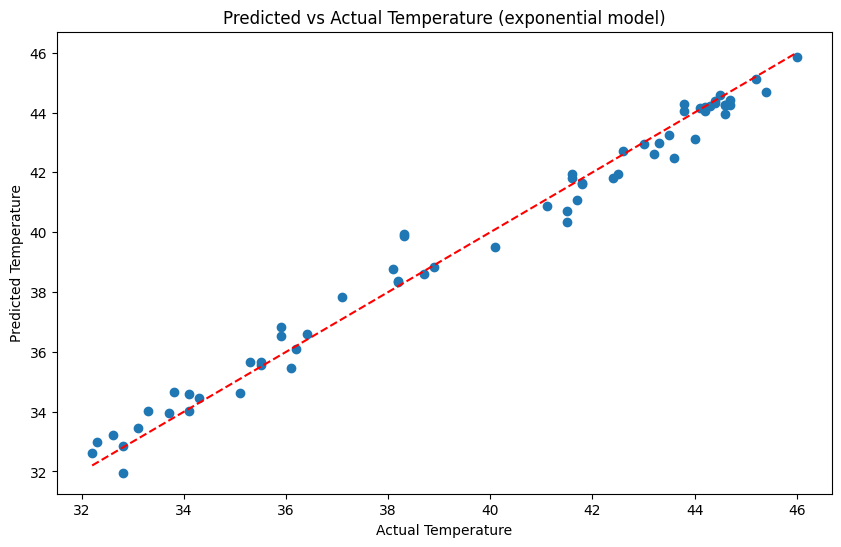

Mean Squared Error: 0.3089
R2 Score: 0.9836

Best model: spherical

Predictions for cleaned_nh_data.csv:
  nh_number   latitude  longitude  predicted_temperature
0     NH 30  21.245244  81.641856              44.139748
1     NH 30  21.245121  81.641838              44.139782
2     NH 30  21.245101  81.641837              44.139787
3     NH 30  21.245012  81.641832              44.139809
4     NH 30  21.244820  81.641837              44.139852
5     NH 30  21.244607  81.641851              44.139898
6     NH 30  21.244021  81.641911              44.140016
7     NH 30  21.243510  81.641932              44.140128
8     NH 30  21.243429  81.641932              44.140147
9     NH 30  21.243333  81.641941              44.140167

Results saved to nh_data_with_predictions.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the temperature data
temp_file_path = 'india_temperature_data_filtered.csv'
df_temp = pd.read_csv(temp_file_path)

temp_col = '7day_max_temp'
lat_col = 'latitude'
lon_col = 'longitude'

# Function to perform kriging and plot results
def perform_kriging(X_train, y_train, X_test, y_test, variogram_model='spherical'):
    OK = OrdinaryKriging(
        X_train[:, 0],
        X_train[:, 1],
        y_train,
        variogram_model=variogram_model,
        verbose=False,
        enable_plotting=False,
    )



    # Make predictions
    y_pred, _ = OK.execute('points', X_test[:, 0], X_test[:, 1])

    # Plot predicted vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Temperature')
    plt.ylabel('Predicted Temperature')
    plt.title(f'Predicted vs Actual Temperature ({variogram_model} model)')
    plt.savefig(f'Predicted_vs_Actual_Temperature{variogram_model}.png')
    plt.show()

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R2 Score: {r2:.4f}')

    return OK

# Split data into train and test sets
X = df_temp[[lon_col, lat_col]].values
y = df_temp[temp_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform kriging with different variogram models
models = ['linear', 'power', 'gaussian', 'spherical', 'exponential']
best_model = None
best_r2 = -np.inf

for model in models:
    print(f"\nPerforming kriging with {model} variogram model:")
    OK = perform_kriging(X_train, y_train, X_test, y_test, variogram_model=model)

    # Select the best model based on R2 score
    r2 = r2_score(y_test, OK.execute('points', X_test[:, 0], X_test[:, 1])[0])
    if r2 > best_r2:
        best_r2 = r2
        best_model = OK

print(f"\nBest model: {best_model.variogram_model}")

# Load the new data
nh_file_path = 'cleaned_nh_data.csv'
df_nh = pd.read_csv(nh_file_path)

# Make predictions on new data
nh_predictions, _ = best_model.execute('points', df_nh['longitude'], df_nh['latitude'])

# Add predictions to the dataframe
df_nh['predicted_temperature'] = nh_predictions

# Display the first few rows of the results
print("\nPredictions for cleaned_nh_data.csv:")
print(df_nh.head(10))

# Save the results to a new CSV file
output_file_path = 'nh_data_with_predictions.csv'
df_nh.to_csv(output_file_path, index=False)
print(f"\nResults saved to {output_file_path}")

#Cross Validation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the temperature data
temp_file_path = 'india_temperature_data_filtered.csv'
df_temp = pd.read_csv(temp_file_path)

temp_col = '7day_max_temp'
lat_col = 'latitude'
lon_col = 'longitude'

# Function to perform kriging and plot results
def perform_kriging(X_train, y_train, X_test, y_test, variogram_model='spherical'):
    OK = OrdinaryKriging(
        X_train[:, 0],
        X_train[:, 1],
        y_train,
        variogram_model=variogram_model,
        verbose=False,
        enable_plotting=False,
    )

    # Make predictions
    y_pred, y_std = OK.execute('points', X_test[:, 0], X_test[:, 1])

    # Plot predicted vs actual with uncertainty
    plt.figure(figsize=(10, 6))
    plt.errorbar(y_test, y_pred, yerr=y_std, fmt='o', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Temperature')
    plt.ylabel('Predicted Temperature')
    plt.title(f'Predicted vs Actual Temperature ({variogram_model} model)')
    plt.savefig(f'predicted_vs_actual_{variogram_model}.png')
    plt.close()

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R2 Score: {r2:.4f}')

    return OK, r2

# Split data into train and test sets
X = df_temp[[lon_col, lat_col]].values
y = df_temp[temp_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform kriging with different variogram models
models = ['linear', 'power', 'gaussian', 'spherical', 'exponential']
best_model = None
best_r2 = -np.inf

for model in models:
    print(f"\nPerforming kriging with {model} variogram model:")
    OK, r2 = perform_kriging(X_train, y_train, X_test, y_test, variogram_model=model)

    if r2 > best_r2:
        best_r2 = r2
        best_model = OK

print(f"\nBest model: {best_model.variogram_model}")

# Load the new data
nh_file_path = 'cleaned_nh_data.csv'
df_nh = pd.read_csv(nh_file_path)

# Make predictions on new data
nh_predictions, nh_std = best_model.execute('points', df_nh['longitude'], df_nh['latitude'])

# Add predictions and uncertainty to the dataframe
df_nh['predicted_temperature'] = nh_predictions
df_nh['prediction_uncertainty'] = nh_std

# Display the first few rows of the results
print("\nPredictions for cleaned_nh_data.csv:")
print(df_nh.head(10))

# Save the results to a new CSV file
output_file_path = 'nh_data_with_predictions_and_uncertainty.csv'
df_nh.to_csv(output_file_path, index=False)
print(f"\nResults saved to {output_file_path}")

# Create a map of India with predictions and uncertainty
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df_nh['longitude'], df_nh['latitude'],
                      c=df_nh['predicted_temperature'],
                      s=df_nh['prediction_uncertainty']*10,  # Adjust size based on uncertainty
                      cmap='viridis',
                      alpha=0.6)
plt.colorbar(scatter, label='Predicted Temperature (°C)')
plt.title('Predicted Temperatures and Uncertainty for National Highways')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('india_temperature_predictions_map.png')
plt.close()

print("Map of predictions and uncertainty saved as 'india_temperature_predictions_map.png'")

# Create a histogram of prediction uncertainties
plt.figure(figsize=(10, 6))
plt.hist(df_nh['prediction_uncertainty'], bins=30, edgecolor='black')
plt.title('Distribution of Prediction Uncertainties')
plt.xlabel('Prediction Uncertainty (°C)')
plt.ylabel('Frequency')
plt.savefig('prediction_uncertainty_histogram.png')
plt.close()

print("Histogram of prediction uncertainties saved as 'prediction_uncertainty_histogram.png'")


Performing kriging with linear variogram model:
Mean Squared Error: 6.1167
R2 Score: 0.6755

Performing kriging with power variogram model:
Mean Squared Error: 1.1757
R2 Score: 0.9376

Performing kriging with gaussian variogram model:
Mean Squared Error: 0.6992
R2 Score: 0.9629

Performing kriging with spherical variogram model:
Mean Squared Error: 0.3012
R2 Score: 0.9840

Performing kriging with exponential variogram model:
Mean Squared Error: 0.3089
R2 Score: 0.9836

Best model: spherical

Predictions for cleaned_nh_data.csv:
  nh_number   latitude  longitude  predicted_temperature  \
0     NH 30  21.245244  81.641856              44.139748   
1     NH 30  21.245121  81.641838              44.139782   
2     NH 30  21.245101  81.641837              44.139787   
3     NH 30  21.245012  81.641832              44.139809   
4     NH 30  21.244820  81.641837              44.139852   
5     NH 30  21.244607  81.641851              44.139898   
6     NH 30  21.244021  81.641911            

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pykrige.ok import OrdinaryKriging

# Load the data
file_path = 'india_temperature_data_filtered.csv'
df = pd.read_csv(file_path)

temp_col = '7day_max_temp'
lat_col = 'latitude'
lon_col = 'longitude'

# Prepare for kriging
# Create a grid of points to krige
grid_lon = np.linspace(df[lon_col].min(), df[lon_col].max(), 100)
grid_lat = np.linspace(df[lat_col].min(), df[lat_col].max(), 100)

# Perform Ordinary Kriging
OK = OrdinaryKriging(
    df[lon_col],
    df[lat_col],
    df[temp_col],
    variogram_model='spherical',
    verbose=False,
    enable_plotting=False,
)

z, ss = OK.execute("grid", grid_lon, grid_lat)

# Plot the kriging results
plt.figure(figsize=(12, 8))
plt.imshow(
    z,
    extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
    origin="lower",
    cmap="viridis",
)
plt.colorbar(label="Temperature (°C)")
plt.title("Ordinary Kriging Interpolation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.scatter(df[lon_col], df[lat_col], c="red", s=10, alpha=0.5)
plt.show()



KeyboardInterrupt: 

#prediction map


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

# Load the data
temp_data = pd.read_csv('india_temperature_data_filtered.csv')
nh_data = pd.read_csv('new_cleaned_national_highways_no_outliers.csv')

# Prepare the data for Kriging
X = temp_data['longitude'].values
Y = temp_data['latitude'].values
Z = temp_data['7day_max_temp'].values

# Create and fit the Ordinary Kriging model
ok = OrdinaryKriging(
    X, Y, Z,
    variogram_model='spherical',
    verbose=False,
    enable_plotting=False,
)

# Prepare the grid for prediction
grid_lon = np.linspace(nh_data['longitude'].min(), nh_data['longitude'].max(), 100)
grid_lat = np.linspace(nh_data['latitude'].min(), nh_data['latitude'].max(), 100)

# Perform the Kriging interpolation
z, ss = ok.execute('grid', grid_lon, grid_lat)

# Predict temperatures for NH points
nh_lon = nh_data['longitude'].values
nh_lat = nh_data['latitude'].values
nh_temp_pred, nh_temp_std = ok.execute('points', nh_lon, nh_lat)

# Add predictions to NH data
nh_data['predicted_temp'] = nh_temp_pred
nh_data['prediction_std'] = nh_temp_std

# Plot the results
plt.figure(figsize=(15, 10))

# Plot kriging interpolation
im = plt.imshow(z, extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
                origin='lower', cmap='viridis', alpha=0.7)

# Plot NH points with predicted temperatures
scatter = plt.scatter(nh_data['longitude'], nh_data['latitude'],
                      c=nh_data['predicted_temp'], cmap='plasma',
                      s=50, edgecolor='black', linewidth=0.5)

# Customize the plot
plt.title("Predicted Temperatures for NH Points on Kriging Interpolation Map", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)

# Add colorbars
cbar_kriging = plt.colorbar(im, label="Interpolated Temperature (°C)", pad=0.01)
cbar_nh = plt.colorbar(scatter, label="Predicted NH Temperature (°C)", pad=0.05)

plt.tight_layout()
plt.show()
plt.savefig(f'final-predicted_nh_temp.png')


<Figure size 640x480 with 0 Axes>

#Range and standard deviation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from scipy.spatial.distance import pdist, squareform

# Load the data
temp_data = pd.read_csv('india_temperature_data_filtered.csv')
nh_data = pd.read_csv('new_cleaned_national_highways_no_outliers.csv')

# Prepare the data for Kriging
X = temp_data['longitude'].values
Y = temp_data['latitude'].values
Z = temp_data['7day_max_temp'].values

# Compute the empirical variogram
coords = np.column_stack((X, Y))
d = pdist(coords)
d = squareform(d)

# Bin the distances
bins = np.linspace(0, np.max(d), 20)
bin_centers = (bins[1:] + bins[:-1]) / 2

gamma = np.zeros(len(bin_centers))
for i in range(len(bin_centers)):
    mask = (d >= bins[i]) & (d < bins[i+1])
    gamma[i] = np.mean(((Z[:, None] - Z[None, :])**2)[mask]) / 2

# Estimate variogram parameters
range_est = bin_centers[np.argmax(gamma)]
sill_est = np.max(gamma)
nugget_est = np.min(gamma)

# Create and fit the Ordinary Kriging model
try:
    ok = OrdinaryKriging(
        X, Y, Z,
        variogram_model='spherical',
        variogram_parameters={'range': range_est, 'sill': sill_est, 'nugget': nugget_est},
        verbose=False,
        enable_plotting=False,
    )

    # Prepare the grid for prediction
    grid_lon = np.linspace(nh_data['longitude'].min(), nh_data['longitude'].max(), 100)
    grid_lat = np.linspace(nh_data['latitude'].min(), nh_data['latitude'].max(), 100)

    # Perform the Kriging interpolation
    z, ss = ok.execute('grid', grid_lon, grid_lat)

    # Predict temperatures for NH points
    nh_lon = nh_data['longitude'].values
    nh_lat = nh_data['latitude'].values
    nh_temp_pred, nh_temp_std = ok.execute('points', nh_lon, nh_lat)

    # Add predictions to NH data
    nh_data['predicted_temp'] = nh_temp_pred
    nh_data['prediction_std'] = nh_temp_std

    # Plot the results
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    # Plot kriging interpolation
    im1 = axs[0, 0].imshow(z, extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
                           origin='lower', cmap='viridis', alpha=0.7)
    scatter1 = axs[0, 0].scatter(nh_data['longitude'], nh_data['latitude'],
                                 c=nh_data['predicted_temp'], cmap='plasma',
                                 s=50, edgecolor='black', linewidth=0.5)
    axs[0, 0].set_title("Predicted Temperatures for NH Points", fontsize=16)
    axs[0, 0].set_xlabel("Longitude", fontsize=12)
    axs[0, 0].set_ylabel("Latitude", fontsize=12)
    plt.colorbar(im1, ax=axs[0, 0], label="Interpolated Temperature (°C)")
    plt.colorbar(scatter1, ax=axs[0, 0], label="Predicted NH Temperature (°C)")

    # Plot kriging standard error
    im2 = axs[0, 1].imshow(np.sqrt(ss), extent=[grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()],
                           origin='lower', cmap='YlOrRd', alpha=0.7)
    axs[0, 1].set_title("Kriging Standard Error", fontsize=16)
    axs[0, 1].set_xlabel("Longitude", fontsize=12)
    axs[0, 1].set_ylabel("Latitude", fontsize=12)
    plt.colorbar(im2, ax=axs[0, 1], label="Standard Error (°C)")

    # Plot variogram
    axs[1, 0].plot(bin_centers, gamma, 'ko-', label='Empirical')
    axs[1, 0].set_xlabel('Distance (degrees)')
    axs[1, 0].set_ylabel('Semivariance')
    axs[1, 0].legend()
    axs[1, 0].set_title('Empirical Variogram')

    # Print variogram parameters
    range_km = range_est * 111  # Convert to km (approximate)
    axs[1, 1].axis('off')
    axs[1, 1].text(0.1, 0.9, f"Estimated Range: {range_est:.2f} degrees ({range_km:.2f} km)", fontsize=12)
    axs[1, 1].text(0.1, 0.8, f"Estimated Sill: {sill_est:.2f}", fontsize=12)
    axs[1, 1].text(0.1, 0.7, f"Estimated Nugget: {nugget_est:.2f}", fontsize=12)

    plt.tight_layout()
    plt.show()

    # Save the results
    nh_data.to_csv('nh_predicted_temperatures_kriging.csv', index=False)
    print("Predictions saved to 'nh_predicted_temperatures_kriging.csv'")

except Exception as e:
    print(f"An error occurred during kriging: {e}")
    print("Plotting available data without kriging...")

    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(temp_data['longitude'], temp_data['latitude'],
                         c=temp_data['7day_max_temp'], cmap='viridis',
                         s=50, edgecolor='black', linewidth=0.5)
    ax.set_title("7-day Max Temperatures", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    plt.colorbar(scatter, label="Temperature (°C)")
    plt.show()

# Print estimated variogram parameters
print(f"Estimated Range: {range_est:.2f} degrees ({range_km:.2f} km)")
print(f"Estimated Sill: {sill_est:.2f}")
print(f"Estimated Nugget: {nugget_est:.2f}")

Predictions saved to 'nh_predicted_temperatures_kriging.csv'
Estimated Range: 17.35 degrees (1926.18 km)
Estimated Sill: 28.21
Estimated Nugget: 0.33


In [ ]:
import pandas as pd
import numpy as np
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist

# Load the data
temp_data = pd.read_csv('india_temperature_data_filtered.csv')
nh_data = pd.read_csv('new_cleaned_national_highways_no_outliers.csv')

# Prepare the data for Kriging
X = temp_data['longitude'].values
Y = temp_data['latitude'].values
Z = temp_data['7day_max_temp'].values

# Function to plot semivariogram and fit the theoretical model
def plot_semivariogram(X, Y, Z, model_type):
    # Calculate pairwise distances and semivariance
    coords = np.column_stack((X, Y))
    distances = pdist(coords)
    diff = pdist(Z.reshape(-1, 1))
    semivariance = 0.5 * diff**2

    # Bin the data
    bin_edges = np.linspace(0, np.max(distances), 20)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    bin_indices = np.digitize(distances, bin_edges)
    binned_semivariance = [np.mean(semivariance[bin_indices == i]) for i in range(1, len(bin_edges))]

    # Fit the model using Kriging
    ok = OrdinaryKriging(X, Y, Z, variogram_model=model_type, verbose=False, enable_plotting=False)

    # Extract model parameters
    sill, range_param, nugget = ok.variogram_model_parameters[:3]

    # Calculate theoretical semivariance
    if model_type == 'spherical':
        model_semivariance = [
            nugget + sill * (1.5 * (h / range_param) - 0.5 * (h / range_param) ** 3) if h <= range_param else nugget + sill
            for h in bin_centers
        ]
    elif model_type == 'exponential':
        model_semivariance = [nugget + sill * (1 - np.exp(-h / range_param)) for h in bin_centers]
    elif model_type == 'gaussian':
        model_semivariance = [nugget + sill * (1 - np.exp(-(h / range_param) ** 2)) for h in bin_centers]
    elif model_type == 'linear':
        model_semivariance = [nugget + min(sill, h * sill / range_param) for h in bin_centers]
    elif model_type == 'circular':
        model_semivariance = [
            nugget + sill * (1 - (2/np.pi) * (np.arccos(min(h/range_param, 1)) - (h/range_param) * np.sqrt(1 - min((h/range_param)**2, 1))))
            if h <= range_param else nugget + sill
            for h in bin_centers
        ]
    else:
        raise ValueError(f"Unsupported variogram model: {model_type}")

    # Plot empirical and theoretical semivariograms
    plt.figure(figsize=(10, 6))
    plt.scatter(bin_centers, binned_semivariance, label='Empirical', color='blue')
    plt.plot(bin_centers, model_semivariance, label=f'{model_type.capitalize()} Model', color='red')
    plt.xlabel('Distance')
    plt.ylabel('Semivariance')
    plt.title(f'Semivariogram - {model_type.capitalize()} Model')
    plt.legend()
    plt.savefig(f'semivariogram_{model_type}.png')
    plt.close()

    # Calculate MSE for model evaluation
    mse = mean_squared_error(binned_semivariance, model_semivariance)

    return mse, sill, range_param, nugget

# Compare different variogram models
models = ['spherical']  # You can add more models like 'linear', 'circular'
results = {}

for model in models:
    mse, sill, range_param, nugget = plot_semivariogram(X, Y, Z, model)
    results[model] = {'mse': mse, 'sill': sill, 'range': range_param, 'nugget': nugget}
    print(f"{model.capitalize()} Model:")
    print(f"  MSE: {mse:.4f}")
    print(f"  Sill: {sill:.2f}")
    print(f"  Range: {range_param:.2f} degrees")
    print(f"  Nugget: {nugget:.2f}")

# Identify the best model based on MSE
best_model = min(results, key=lambda x: results[x]['mse'])
print(f"\nBest fitting model: {best_model.capitalize()}")

# Use the best model for kriging
ok = OrdinaryKriging(X, Y, Z, variogram_model=best_model, verbose=False, enable_plotting=False)

# If the best model is spherical, print the range in degrees and kilometers
if best_model == 'spherical':
    range_value_deg = results['spherical']['range']
    range_value_km = range_value_deg * 111  # Convert degrees to kilometers
    print(f"Distance after which semivariance becomes constant (range): {range_value_deg:.2f} degrees ({range_value_km:.2f} km)")


Spherical Model:
  MSE: 47.1847
  Sill: 19.04
  Range: 13.82 degrees
  Nugget: 0.00

Best fitting model: Spherical
Distance after which semivariance becomes constant (range): 13.82 degrees (1534.14 km)


#AFTER MINOR


# Clean Temperature data
within indian range



In [ ]:
import os
import pandas as pd
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt

# Simplified polygon representing India's boundaries (rough approximation)
india_coords = [
    (68.1, 7.9), (97.4, 7.9), (97.4, 35.5), (68.1, 35.5)
]
india_polygon = Polygon(india_coords)

def is_point_in_india(lat, lon):
    return india_polygon.contains(Point(lon, lat))

# Input file path (general purpose, replace with actual paths)
file_path = '/content/Tempdata - 95%1DayMin.csv'  # Update this to your actual file path

# Read the original temperature data
df = pd.read_csv(file_path)

# Assume first 2 columns are Latitude and Longitude
latitude_col = 0  # First column (Latitude)
longitude_col = 1  # Second column (Longitude)
temperature_col = df.columns[2]  # The 3rd column (Temperature data)

# Filter points within India
df['in_india'] = df.apply(lambda row: is_point_in_india(row[df.columns[latitude_col]], row[df.columns[longitude_col]]), axis=1)
df_india = df[df['in_india']].drop(columns=['in_india'])

# Save the filtered data with the '-cleaned' suffix
file_name, file_extension = os.path.splitext(os.path.basename(file_path))  # Get the file name without extension
output_path = f'/content/{file_name}-cleaned{file_extension}'  # Create the new file name with '-cleaned'

df_india.to_csv(output_path, index=False)

print(f"Original data points: {len(df)}")
print(f"Data points within India: {len(df_india)}")
print(f"Filtered data saved to '{output_path}'")

# Optional: Visualize the points (using only the 3rd column for visualization)
plt.figure(figsize=(12, 8))
x, y = india_polygon.exterior.xy
plt.plot(x, y, 'k-')
plt.scatter(df_india[df.columns[longitude_col]], df_india[df.columns[latitude_col]],
            c=df_india[temperature_col], cmap='viridis', s=10)  # Using the 3rd temperature column
plt.colorbar(label='Temperature (°C)')
plt.title('Temperature Data Points within India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(68, 98)
plt.ylim(7, 36)
plt.tight_layout()
plt.show()


Original data points: 329
Data points within India: 320
Filtered data saved to '/content/Tempdata - 95%1DayMin-cleaned.csv'


#Apply kriging on cleaned NH coordinates with all 6 files and merge

##Actual Kriging

In [ ]:
import pandas as pd
import numpy as np
from pykrige.ok import OrdinaryKriging
import os
import matplotlib.pyplot as plt

def apply_kriging_on_NH(temp_data, nh_data, temperature_col, model='spherical'):
    """
    Apply Kriging interpolation using spherical model on NH coordinates.

    Parameters:
    - temp_data: DataFrame containing temperature data (latitude, longitude, temperature)
    - nh_data: DataFrame containing NH coordinates (name, latitude, longitude)
    - temperature_col: Column name of temperature data to use for interpolation
    - model: Kriging model type ('spherical', 'exponential', etc.)

    Returns:
    - nh_data: DataFrame with an additional column of predicted temperatures
    """
    # Extract coordinates and temperature values from temp_data
    X = temp_data['Longitude'].values
    Y = temp_data['Latitude'].values
    Z = temp_data[temperature_col].values

    # Create and fit the Ordinary Kriging model
    ok = OrdinaryKriging(
        X, Y, Z,
        variogram_model=model,
        verbose=False,
        enable_plotting=False,
    )

    # Predict temperatures for NH points
    nh_lon = nh_data['Longitude'].values
    nh_lat = nh_data['Latitude'].values
    nh_temp_pred, nh_temp_std = ok.execute('points', nh_lon, nh_lat)

    # Add predictions to NH data
    nh_data[f'{temperature_col}_predicted'] = nh_temp_pred

    return nh_data

# Function to load temperature data and NH coordinates, apply Kriging, and save the results
def process_kriging(temp_file, nh_file, temperature_col, output_dir):
    # Read temperature data and NH coordinates
    temp_data = pd.read_csv(temp_file)
    nh_data = pd.read_csv(nh_file)

    # Ensure we have valid data (remove rows with missing coordinates or temperature)
    temp_data = temp_data.dropna(subset=['Latitude', 'Longitude', temperature_col])
    nh_data = nh_data.dropna(subset=['Latitude', 'Longitude'])

    # Apply Kriging to predict temperature at NH coordinates
    nh_data_with_predictions = apply_kriging_on_NH(temp_data, nh_data, temperature_col)

    # Save the resulting data to a new CSV file
    output_file = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(nh_file))[0]}_with_{temperature_col}_predicted.csv")
    nh_data_with_predictions.to_csv(output_file, index=False)
    print(f"Kriged data with predicted temperature saved to: {output_file}")

    # Basic analysis of the predictions
    print("\nSummary of predictions for NH points:")
    print(nh_data_with_predictions[f'{temperature_col}_predicted'].describe())

    # Compare predictions with nearest known points
    from scipy.spatial.distance import cdist

    nh_data_with_predictions.to_csv(output_file, index=False)
    print(f"Kriged data with predicted temperature saved to: {output_file}")

# Example usage
# Replace the paths and temperature column name as necessary
temp_file = '/content/Tempdata - 95%1DayMin-cleaned.csv'  # Path to your temperature data file
nh_file = '/content/NHdatapoints.csv'  # Path to your NH coordinates file
temperature_col = '95%, 1 Day Min'  # Replace with the specific column for temperature you want to use
output_dir = '/content/'  # Directory where you want to save the output file

# Apply Kriging and save the results
process_kriging(temp_file, nh_file, temperature_col, output_dir)

Kriged data with predicted temperature saved to: /content/NHdatapoints_with_95%, 1 Day Min_predicted.csv

Summary of predictions for NH points:
count    748068.000000
mean          4.784896
std           4.212002
min          -7.030768
25%           2.257980
50%           4.627900
75%           6.835004
max          17.471355
Name: 95%, 1 Day Min_predicted, dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning:




Kriged data with predicted temperature saved to: /content/NHdatapoints_with_95%, 1 Day Min_predicted.csv


##mean column

In [ ]:
merged_data = pd.read_csv('/content/NH-merged_7 Day Max_predicted.csv')


# Calculate the mean of the 3 columns for each row and create a new column '1Day Min'
merged_data['7Day Max'] = merged_data[['50%, 7 Day Max_predicted', '95%, 7 Day Max_predicted', '99%, 7 Day Max_predicted']].mean(axis=1)

# Save the updated DataFrame to a new CSV file
merged_data.to_csv('NHmerged_7 Day Max_predicted-mean.csv', index=False)

# Display the updated data (optional)
print(merged_data)

         name   Latitude  Longitude  50%, 7 Day Max_predicted  \
0       NH 30  21.245244  81.641856                 44.250822   
1       NH 30  21.245121  81.641838                 44.250868   
2       NH 30  21.245101  81.641837                 44.250875   
3       NH 30  21.245012  81.641832                 44.250908   
4       NH 30  21.244820  81.641837                 44.250975   
...       ...        ...        ...                       ...   
748063  NH 49  21.674185  85.612577                 42.068205   
748064  NH 49  21.675141  85.614081                 42.067645   
748065  NH 49  21.676748  85.616568                 42.066722   
748066  NH 49  21.676748  85.616568                 42.066722   
748067  NH 49  21.677261  85.617469                 42.066386   

        95%, 7 Day Max_predicted  99%, 7 Day Max_predicted   7Day Max  
0                      45.210531                 46.113581  45.191645  
1                      45.210565                 46.113615  45.191683  
2  

#Change point algo


##cleaned NH with >5km and temp z score

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats import zscore
from geopy.distance import geodesic

# Path to the CSV file
file_path = '/content/NHmerged_7 Day Max_predicted-mean.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Filter rows where 'name' is 'NH 62'
df_new = df[df['name'] == 'NH 31'].copy()


def filter_points(df, max_distance_km=5, max_temp_deviation=3):
    """
    Filter points with a more nuanced approach

    Parameters:
    - df: Input DataFrame
    - max_distance_km: Maximum allowed distance between consecutive points
    - max_temp_deviation: Number of standard deviations for temperature filtering

    Returns:
    Filtered DataFrame
    """
    # Sort by latitude and longitude to preserve route order
    df_sorted = df.sort_values(by=['Latitude', 'Longitude']).reset_index(drop=True)

    # Identify outliers using temperature Z-score
    df_sorted['temp_zscore'] = np.abs(zscore(df_sorted['7Day Max']))

    # Filter out extreme temperature points
    df_filtered = df_sorted[df_sorted['temp_zscore'] <= max_temp_deviation].copy()

    # Remove points that are too close to each other
    points_to_keep = [0]  # Always keep the first point

    for i in range(1, len(df_filtered)):
        current_point = (df_filtered.iloc[i]['Latitude'], df_filtered.iloc[i]['Longitude'])
        previous_point = (df_filtered.iloc[points_to_keep[-1]]['Latitude'],
                          df_filtered.iloc[points_to_keep[-1]]['Longitude'])

        distance = geodesic(previous_point, current_point).km

        # Keep point if it's far enough from the previous kept point
        if distance >= max_distance_km:
            points_to_keep.append(i)

    # Final filtered DataFrame
    cleaned_df = df_filtered.iloc[points_to_keep].reset_index(drop=True)

    print(f"Original points: {len(df)}")
    print(f"Points after filtering: {len(cleaned_df)}")

    return cleaned_df

# Use the function
cleaned_df = filter_points(df_new, max_distance_km=5, max_temp_deviation=3)

# Extract the highway name from the DataFrame (assuming all rows in df_new have the same 'name' value)
highway_name = df_new['name'].iloc[0]  # Get the first entry for highway name, as it's consistent

# Save the cleaned DataFrame to a new CSV file with dynamic filename
cleaned_df.to_csv(f'/content/{highway_name}_7 Day Max_cleaned_data.csv', index=False)

# # Before plotting
# print("Cleaned DataFrame:")
# print(cleaned_df)
# print("\nColumn names:", cleaned_df.columns)
# print("\nLatitude range:", cleaned_df['Latitude'].min(), cleaned_df['Latitude'].max())
# print("Longitude range:", cleaned_df['Longitude'].min(), cleaned_df['Longitude'].max())
# print("\n7Day Max temperature range:",
#       cleaned_df['7Day Max'].min(),
#       cleaned_df['7Day Max'].max())

# Update the title dynamically based on the highway name
fig = px.scatter_mapbox(
    cleaned_df,
    lat="Latitude",
    lon="Longitude",
    color="7Day Max",
    hover_name="7Day Max",  # Add hover information
    hover_data=["Latitude", "Longitude"],
    color_continuous_scale=px.colors.sequential.Viridis,
    size="7Day Max",
    size_max=15,  # Increase marker size
    zoom=6,  # Adjust zoom level
    center={"lat": cleaned_df['Latitude'].mean(),
            "lon": cleaned_df['Longitude'].mean()},  # Dynamic center
    mapbox_style="open-street-map",
    title=f"Cleaned {highway_name} Data Points with Predicted 7-Day Max Temperatures"
)

# Increase marker opacity
fig.update_traces(marker=dict(opacity=0.7))


Original points: 19784
Points after filtering: 10132


##original NH view

In [ ]:
df_original = pd.read_csv('/content/NHmerged_7 Day Max_predicted-mean.csv')

# Filter rows where 'name' is 'NH 67'
df_original = df[df['name'] == 'NH 62'].copy()

# Extract the highway name from the DataFrame (assuming all rows in df_new have the same 'name' value)
highway_name = df_original['name'].iloc[0]  # Get the first entry for highway name, as it's consistent


# Update the title dynamically based on the highway name
fig = px.scatter_mapbox(
    df_original ,
    lat="Latitude",
    lon="Longitude",
    color="7Day Max",
    hover_name="7Day Max",  # Add hover information
    hover_data=["Latitude", "Longitude"],
    color_continuous_scale=px.colors.sequential.Viridis,
    size="7Day Max",
    size_max=15,  # Increase marker size
    zoom=6,  # Adjust zoom level
    center={"lat": cleaned_df['Latitude'].mean(),
            "lon": cleaned_df['Longitude'].mean()},  # Dynamic center
    mapbox_style="open-street-map",
    title=f"Original {highway_name} Data Points with Predicted 7-Day Max Temperatures"
)

# Increase marker opacity
fig.update_traces(marker=dict(opacity=0.7))

##visualise segment

In [ ]:
def visualize_segments(nh_data, temperature_column, change_points,
                      change_lats, change_lons, segments , highway_name):
    """Visualize the segmented highway with change points"""
    import plotly.express as px
    import plotly.graph_objects as go




    fig = px.scatter_mapbox(
        nh_data,
        lat="Latitude",
        lon="Longitude",
        color=temperature_column,
        hover_name=temperature_column,
        hover_data=["Latitude", "Longitude"],
        color_continuous_scale=px.colors.sequential.Viridis,
        size=temperature_column,
        size_max=15,
        zoom=6,
        center={"lat": nh_data['Latitude'].mean(),
                "lon": nh_data['Longitude'].mean()},
        mapbox_style="open-street-map",
        title=f"Highway Segments with Temperature Change Points for {highway_name}"
    )

    # Add change points as red markers
    fig.add_trace(go.Scattermapbox(
        lat=change_lats,
        lon=change_lons,
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='circle'
        ),
        name='Change Points',
        hovertemplate='Change Point<br>Lat: %{lat:.4f}<br>Lon: %{lon:.4f}'
    ))

    # Increase marker opacity
    fig.update_traces(marker=dict(opacity=0.7))

    fig.update_layout(
        mapbox=dict(
            center=dict(
                lat=nh_data['Latitude'].mean(),
                lon=nh_data['Longitude'].mean()
            ),
            zoom=6
        ),
        margin={"r":0,"t":50,"l":0,"b":0},
        showlegend=True
    )

    fig.show()

##actual change point algo - (pelt + distance matrix)

In [ ]:
import pandas as pd
import numpy as np
import ruptures as rpt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go
import pickle  # for saving intermediate results

def compute_distance_matrix(nh_data):
    """
    Compute the distance matrix for highway points
    """
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371  # Earth's radius in km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    coords = nh_data[['Latitude', 'Longitude']].values
    n_points = len(coords)
    distance_matrix = np.zeros((n_points, n_points))

    for i in range(n_points):
        for j in range(i+1, n_points):
            dist = haversine_distance(coords[i,0], coords[i,1], coords[j,0], coords[j,1])
            distance_matrix[i,j] = distance_matrix[j,i] = dist

    return distance_matrix

def order_highway_points(distance_matrix):
    """
    Order points along the highway using hierarchical clustering
    """
    clustering = AgglomerativeClustering(n_clusters=1, linkage='single',
                                       metric='precomputed')
    clustering.fit(distance_matrix)

    n_points = len(distance_matrix)
    ordered_indices = []
    remaining_indices = set(range(n_points))
    current_idx = 0
    ordered_indices.append(current_idx)
    remaining_indices.remove(current_idx)

    while remaining_indices:
        distances = distance_matrix[current_idx, list(remaining_indices)]
        next_idx = list(remaining_indices)[np.argmin(distances)]
        ordered_indices.append(next_idx)
        remaining_indices.remove(next_idx)
        current_idx = next_idx

    return ordered_indices

def detect_change_points(ordered_temps, penalty=10):
    """
    Detect change points using PELT algorithm
    """
    algo = rpt.Pelt(model="rbf").fit(ordered_temps.reshape(-1, 1))
    return algo.predict(pen=penalty)

def filter_change_points(change_points, ordered_lats, ordered_lons,
                        max_change_points=15, min_distance_km=10):
    """
    Filter change points based on distance and maximum number
    """
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    filtered_change_points = [0]

    for cp in change_points:
        if cp >= len(ordered_lats):
            continue

        valid_point = True
        for existing_cp in filtered_change_points:
            dist = haversine_distance(
                ordered_lats[cp], ordered_lons[cp],
                ordered_lats[existing_cp], ordered_lons[existing_cp]
            )
            if dist < min_distance_km:
                valid_point = False
                break

        if valid_point and len(filtered_change_points) < max_change_points:
            filtered_change_points.append(cp)

    return sorted(filtered_change_points)


def create_segments_with_chainage(filtered_change_points, ordered_temps, ordered_lats, ordered_lons, highway_name):
    """
    Create segment information with chainage distances and save to CSV
    """
    segments = []
    start_km = 0.0

    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    for i in range(len(filtered_change_points) - 1):
        start_idx = filtered_change_points[i]
        end_idx = filtered_change_points[i + 1]
        mean_temp = np.mean(ordered_temps[start_idx:end_idx])
        length_km = haversine_distance(ordered_lats[start_idx], ordered_lons[start_idx], ordered_lats[end_idx], ordered_lons[end_idx])
        end_km = start_km + length_km

        segments.append({
            'start_km': start_km,
            'end_km': end_km,
            'mean_temp': mean_temp
        })
        start_km = end_km

    pd.DataFrame(segments).to_csv(f'{highway_name}_segments_chainage.csv', index=False)
    print(f"Segment information saved to {highway_name}_segments_chainage.csv")
    return segments

# def create_segments(filtered_change_points, ordered_temps, ordered_lats, ordered_lons):
#     """
#     Create segment information from filtered change points
#     """
#     def haversine_distance(lat1, lon1, lat2, lon2):
#         R = 6371
#         lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
#         dlat = lat2 - lat1
#         dlon = lon2 - lon1
#         a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
#         c = 2 * np.arcsin(np.sqrt(a))
#         return R * c

#     segments = []
#     for i in range(len(filtered_change_points)-1):
#         start_idx = filtered_change_points[i]
#         end_idx = filtered_change_points[i+1]
#         segment_temps = ordered_temps[start_idx:end_idx]

#         segments.append({
#             'start_idx': start_idx,
#             'end_idx': end_idx,
#             'mean_temp': np.mean(segment_temps),
#             'std_temp': np.std(segment_temps),
#             'length_km': haversine_distance(
#                 ordered_lats[start_idx], ordered_lons[start_idx],
#                 ordered_lats[end_idx], ordered_lons[end_idx]
#             )
#         })

#     return segments


def save_change_point_coordinates_for_highway(filtered_change_points, ordered_lats, ordered_lons, cleaned_df):
    """
    Save the coordinates (lat, lon) of the detected change points to a CSV file based on the highway name.
    """
    highway_name = cleaned_df['name'].iloc[0]  # Get the highway name from the 'name' column
    filename = f'/content/{highway_name}_change_points_coordinates.csv'  # Create a filename with the highway name

    change_points_coords = {
        "Latitude": ordered_lats[filtered_change_points],
        "Longitude": ordered_lons[filtered_change_points]
    }
    change_points_df = pd.DataFrame(change_points_coords)

    change_points_df.to_csv(filename, index=False)  # Save coordinates as CSV
    print(f"Change point coordinates saved to {filename}")


# Example usage with saving intermediate results:
def process_highway_data(nh_data, temperature_column, highway_name, max_change_points=10, min_distance_km=10, penalty=10):
    """
    Process highway data with option to save/load intermediate results
    """
    try:
        # Step 1: Compute distance matrix
        print("Computing distance matrix...")
        distance_matrix = compute_distance_matrix(nh_data)

        # Step 2: Order points
        print("Ordering highway points...")
        ordered_indices = order_highway_points(distance_matrix)

        # Step 3: Reorder data
        ordered_temps = nh_data[temperature_column].iloc[ordered_indices].values
        ordered_lats = nh_data['Latitude'].iloc[ordered_indices].values
        ordered_lons = nh_data['Longitude'].iloc[ordered_indices].values

        # Step 4: Detect change points
        print("Detecting change points...")
        change_points = detect_change_points(ordered_temps, penalty)
        #save_intermediate_results(change_points, 'change_points.pkl')

        # Step 5: Filter change points
        print("Filtering change points...")
        filtered_change_points = filter_change_points(
            change_points, ordered_lats, ordered_lons,
            max_change_points, min_distance_km
        )

        # # Step 6: Create segments
        # print("Creating segments...")
        # segments = create_segments(
        #     filtered_change_points, ordered_temps, ordered_lats, ordered_lons
        # )

        # Step 6: Create segments with chainage
        print("Creating segments with chainage...")
        segments = create_segments_with_chainage(
            filtered_change_points, ordered_temps,
            ordered_lats, ordered_lons, highway_name
        )

        # Save change point coordinates as CSV
        save_change_point_coordinates_for_highway(filtered_change_points, ordered_lats, ordered_lons, nh_data)

        # Get final coordinates for visualization
        change_lats = ordered_lats[filtered_change_points]
        change_lons = ordered_lons[filtered_change_points]

        return filtered_change_points, change_lats, change_lons, segments

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None, None, None, None


#Highway name
highway_name = cleaned_df['name'].iloc[0]

# Example of how to use:
temperature_column = "7Day Max"

# Run full process
results = process_highway_data(
    nh_data=cleaned_df,
    temperature_column=temperature_column,
    highway_name=highway_name,
    max_change_points=10,
    min_distance_km=80,
    penalty=10
)

if results[0] is not None:
    change_points, change_lats, change_lons, segments = results
    visualize_segments(cleaned_df, temperature_column, change_points,
                      change_lats, change_lons, segments , highway_name)



Computing distance matrix...
Ordering highway points...
Detecting change points...
Filtering change points...
Creating segments with chainage...
Segment information saved to NH 31_segments_chainage.csv
Change point coordinates saved to /content/NH 31_change_points_coordinates.csv


##visualise chainage

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def determine_vg_grade(mean_temp):
    """
    Determine VG grade based on mean temperature according to IRC:SP:73-2018 guidelines
    """
    if mean_temp < 30:
        return "VG-10"
    elif mean_temp < 38:
        return "VG-20"
    elif mean_temp < 45:
        return "VG-30"
    elif mean_temp > 45:
        return "VG-40"
    else:
        return "VG-50"

def visualize_segments_with_vg(nh_data, temperature_column, change_points,
                             change_lats, change_lons, segments, highway_name):
    """
    Visualize highway segments with VG grades using a map and detailed segment information
    """
    # Convert segments to DataFrame if it's a list
    if isinstance(segments, list):
        segments = pd.DataFrame(segments)

    # Add VG grades to segments
    segments['vg_grade'] = segments['mean_temp'].apply(determine_vg_grade)

    # Save segments with VG grades
    output_filename = f'{highway_name}_segments_with_vg.csv'
    segments.to_csv(output_filename, index=False)
    print(f"Segments with VG grades saved to {output_filename}")

    # Create subplot figure with map and table
    fig = make_subplots(
        rows=2, cols=1,
        specs=[[{"type": "mapbox"}],
               [{"type": "table"}]],
        row_heights=[0.7, 0.3],
        vertical_spacing=0.05
    )

    # Add scatter mapbox trace
    scatter_trace = go.Scattermapbox(
        lat=nh_data["Latitude"],
        lon=nh_data["Longitude"],
        mode='markers',
        marker=dict(
            size=8,
            color=nh_data[temperature_column],
            colorscale='Viridis',
            showscale=True,
            opacity=0.7
        ),
        text=nh_data[temperature_column].round(2).astype(str) + "°C",
        name='Temperature Points'
    )
    fig.add_trace(scatter_trace, row=1, col=1)

    # Add change points
    change_point_texts = []
    for i in range(len(change_lats)):
        if i < len(segments):
            temp = segments['mean_temp'].iloc[i]
            vg = determine_vg_grade(temp)
            text = f"Change Point {i+1}<br>Temp: {temp:.2f}°C<br>VG Grade: {vg}"
        else:
            text = f"Change Point {i+1}"
        change_point_texts.append(text)

    change_points_trace = go.Scattermapbox(
        lat=change_lats,
        lon=change_lons,
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='circle'
        ),
        text=change_point_texts,
        hoverinfo='text',
        name='Change Points'
    )
    fig.add_trace(change_points_trace, row=1, col=1)

    # Add table with segment information
    table_trace = go.Table(
        header=dict(
            values=['Start (km)', 'End (km)', 'Length (km)', 'Mean Temp (°C)', 'VG Grade'],
            font=dict(size=12, color='white'),
            fill_color='darkblue',
            align='left'
        ),
        cells=dict(
            values=[
                segments['start_km'].round(2),
                segments['end_km'].round(2),
                (segments['end_km'] - segments['start_km']).round(2),
                segments['mean_temp'].round(2),
                segments['vg_grade']
            ],
            font=dict(size=11),
            fill_color=[['lightgrey', 'white'] * len(segments)],
            align='left'
        )
    )
    fig.add_trace(table_trace, row=2, col=1)

    # Update layout
    fig.update_layout(
        title=f"{highway_name}: Temperature Segments and VG Grade Analysis",
        mapbox=dict(
            style="open-street-map",
            center=dict(
                lat=nh_data['Latitude'].mean(),
                lon=nh_data['Longitude'].mean()
            ),
            zoom=6
        ),
        height=900,
        showlegend=True,
        margin=dict(t=30, b=10)
    )

    return fig

# Usage example:
if results[0] is not None:
    change_points, change_lats, change_lons, segments = results
    fig = visualize_segments_with_vg(cleaned_df, "7Day Max", change_points,
                                   change_lats, change_lons, segments, highway_name)
    fig.show()

Segments with VG grades saved to NH 31_segments_with_vg.csv
